Input dropout + Sparse

In [1008]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from itertools import product
import pprint


from codes.utils import *
from codes.process import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pp = pprint.PrettyPrinter(indent=4)

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'
y_value = 'y'  # Fix for all analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [734]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_X_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [900]:
# For fold
#fold_num = 1
#in_fold_num = 1

# For model
#learning_rate = 0.01
#sparsity_target = 0.2
#sparsity_weight = 0.3
#dropout_rate = 0.3
#ex_num = 100

# For training
n_epochs = 200
batch_size = 16
#loss_test_min = 1000

In [901]:
def build_data(fold_num, in_fold_num, hparam): 
    # Train data
    bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
    bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

    # Test data
    bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
    bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

    # Data set
    X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
    y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
    X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
    y_test = bed_data_test[y_value].to_numpy().astype(np.int32)
    
    return X_train, y_train, X_test, y_test

def process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam):
    result_list = []
    
    ##### Init #####
    reset_graph(random_seed)
    training = tf.placeholder_with_default(False, shape=(), name='training')
    n_inputs = X_train.shape[1]
    n_hidden = 10
    n_outputs = n_inputs

    ##### Build Model #####
    # input
    X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])

    # layers
    X_drop = tf.layers.dropout(X_input, hparam['dr'], training=training)  # Input dropout
    hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
    hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
    hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
    hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
    hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
    logits = tf.layers.dense(hidden2r, n_outputs)

    # output
    logits = tf.layers.dense(hidden2r, n_outputs)

    ##### Construct Loss #####
    # sparsity loss
    hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)
    sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden_mean))

    # mean info  # Use mae as r_loss
    mae = tf.reduce_mean(tf.abs(logits - X_input))
#    mse = tf.reduce_mean(tf.square(logits-X_input))
#    c_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 

    # Setting
    r_loss = mae

    # Reconstruction Loss
    loss = r_loss + hparam['sw'] * sparsity_loss

    # Optimizer
    optimizer = tf.train.AdamOptimizer(hparam['lr'])
    training_op = optimizer.minimize(loss)
    
    # Execute TF
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    loss_test_min = 1000
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs+1):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print(f'\r{100 * iteration // n_batches}%', end='')
                #sys.stdout.flush()
                X_batch = next(shuffle_X_batch(X_train, batch_size))
                sess.run(training_op, feed_dict={X_input: X_batch})
            if epoch % 10 == 0:
                mae_train, loss_train = sess.run([mae, loss], feed_dict={X_input: X_batch})
                mae_test, loss_test = sess.run([mae, loss], feed_dict={X_input: X_test})
                print(f'\r{epoch} Train, \tMAE: {mae_train: 4f}, \tLoss:, {loss_train:.4f}')
                print(f'\r{epoch} Test, \tMAE: {mae_test: 4f}, \tLoss:, {loss_test:.4f}')
                result_list.append([[epoch, fold_num, in_fold_num, hparam, mae_train, loss_train],
                                    [epoch, fold_num, in_fold_num, hparam, mae_test, loss_test]])
                if (loss_test_min > loss_test and epoch > 0) or epoch ==10:
                    loss_test_min = loss_test
                    saver.save(sess, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value,
                                                  ex=hparam['en'], model_key=get_model_key(hparam), epoch=epoch))
                    print('Save model!')
                
    return result_list

def process_model(fold_num, in_fold_num, hparam):
    X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
    result_list = process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam)

    return result_list

In [919]:
%%time
lr_list = [0.01]
st_list = [0.5]
sw_list = [0.5]
dr_list = [0.5]
#en_list = [100, 1000, 10000]
en_list = [100]

hdict = {}
# Find Hyper parameter
for prod_num, prod_set in enumerate(product(*[lr_list, st_list, sw_list, dr_list, en_list])):
    hparam ={}
    hparam['lr'], hparam['st'], hparam['sw'], hparam['dr'], hparam['en'] = prod_set
    hcv_result = []    
    for fold_num in range(1,6):
#        for in_fold_num in ([None] + list(range(1,6))):
        for in_fold_num in ([None]):
            print(fold_num, in_fold_num)
            hcv_result.append(process_model(fold_num, in_fold_num, hparam))
    hdict[prod_num] = hcv_result  # prod_num -> [[[epoch train], [epoch test]]]

1 None
0 Train, 	MAE:  0.184485, 	Loss:, 0.1924
0 Test, 	MAE:  0.176694, 	Loss:, 1.3012
10 Train, 	MAE:  0.078711, 	Loss:, 0.0852
10 Test, 	MAE:  0.071626, 	Loss:, 0.4377
Save model!
20 Train, 	MAE:  0.054496, 	Loss:, 0.0550
20 Test, 	MAE:  0.052332, 	Loss:, 0.0901
Save model!
30 Train, 	MAE:  0.046643, 	Loss:, 0.0469
30 Test, 	MAE:  0.053139, 	Loss:, 0.0745
Save model!
40 Train, 	MAE:  0.073629, 	Loss:, 0.0739
40 Test, 	MAE:  0.059369, 	Loss:, 0.0759
50 Train, 	MAE:  0.037534, 	Loss:, 0.0452
50 Test, 	MAE:  0.050795, 	Loss:, 0.1180
60 Train, 	MAE:  0.055379, 	Loss:, 0.0555
60 Test, 	MAE:  0.057886, 	Loss:, 0.0693
Save model!
70 Train, 	MAE:  0.065549, 	Loss:, 0.0656
70 Test, 	MAE:  0.052456, 	Loss:, 0.1622
80 Train, 	MAE:  0.040589, 	Loss:, 0.0406
80 Test, 	MAE:  0.057449, 	Loss:, 0.0676
Save model!
90 Train, 	MAE:  0.040045, 	Loss:, 0.0407
90 Test, 	MAE:  0.054893, 	Loss:, 0.0826
100 Train, 	MAE:  0.056195, 	Loss:, 0.0563
100 Test, 	MAE:  0.051157, 	Loss:, 0.0863
110 Train, 	MAE:  0.

0 Train, 	MAE:  0.181166, 	Loss:, 0.1815
0 Test, 	MAE:  0.193036, 	Loss:, 0.3642
10 Train, 	MAE:  0.226131, 	Loss:, 0.2262
10 Test, 	MAE:  0.192799, 	Loss:, 0.2304
Save model!
20 Train, 	MAE:  0.181198, 	Loss:, 0.1812
20 Test, 	MAE:  0.192091, 	Loss:, 0.2029
Save model!
30 Train, 	MAE:  0.202075, 	Loss:, 0.2021
30 Test, 	MAE:  0.191990, 	Loss:, 0.1969
Save model!
40 Train, 	MAE:  0.196586, 	Loss:, 0.1966
40 Test, 	MAE:  0.191679, 	Loss:, 0.1959
Save model!
50 Train, 	MAE:  0.228207, 	Loss:, 0.2282
50 Test, 	MAE:  0.191682, 	Loss:, 0.1929
Save model!
60 Train, 	MAE:  0.216934, 	Loss:, 0.2170
60 Test, 	MAE:  0.191547, 	Loss:, 0.1927
Save model!
70 Train, 	MAE:  0.211040, 	Loss:, 0.2110
70 Test, 	MAE:  0.191451, 	Loss:, 0.1922
Save model!
80 Train, 	MAE:  0.097279, 	Loss:, 0.0983
80 Test, 	MAE:  0.091414, 	Loss:, 0.1304
Save model!
90 Train, 	MAE:  0.077681, 	Loss:, 0.0778
90 Test, 	MAE:  0.079199, 	Loss:, 0.0864
Save model!
100 Train, 	MAE:  0.066072, 	Loss:, 0.0662
100 Test, 	MAE:  0.07

100 Train, 	MAE:  0.095291, 	Loss:, 0.0961
100 Test, 	MAE:  0.121838, 	Loss:, 0.2524
110 Train, 	MAE:  0.085871, 	Loss:, 0.0876
110 Test, 	MAE:  0.106453, 	Loss:, 0.1737
Save model!
120 Train, 	MAE:  0.170295, 	Loss:, 0.1708
120 Test, 	MAE:  0.106180, 	Loss:, 0.1324
Save model!
130 Train, 	MAE:  0.181564, 	Loss:, 0.1912
130 Test, 	MAE:  0.175274, 	Loss:, 0.7508
140 Train, 	MAE:  0.093591, 	Loss:, 0.0940
140 Test, 	MAE:  0.109403, 	Loss:, 0.1342
150 Train, 	MAE:  0.111136, 	Loss:, 0.1116
150 Test, 	MAE:  0.119286, 	Loss:, 0.1412
160 Train, 	MAE:  0.128733, 	Loss:, 0.1298
160 Test, 	MAE:  0.100894, 	Loss:, 0.1661
170 Train, 	MAE:  0.153215, 	Loss:, 0.1541
170 Test, 	MAE:  0.168961, 	Loss:, 0.2022
180 Train, 	MAE:  0.120054, 	Loss:, 0.1204
180 Test, 	MAE:  0.115122, 	Loss:, 0.1372
190 Train, 	MAE:  0.082415, 	Loss:, 0.0828
190 Test, 	MAE:  0.118030, 	Loss:, 0.1461
200 Train, 	MAE:  0.158323, 	Loss:, 0.1593
200 Test, 	MAE:  0.176316, 	Loss:, 0.2346
4 None
0 Train, 	MAE:  0.085525, 	Loss:, 

0 Train, 	MAE:  0.136420, 	Loss:, 0.1836
0 Test, 	MAE:  0.209460, 	Loss:, 1.4877
10 Train, 	MAE:  0.089673, 	Loss:, 0.1020
10 Test, 	MAE:  0.096649, 	Loss:, 0.7903
Save model!
20 Train, 	MAE:  0.076661, 	Loss:, 0.0773
20 Test, 	MAE:  0.064329, 	Loss:, 0.1174
Save model!
30 Train, 	MAE:  0.057235, 	Loss:, 0.0581
30 Test, 	MAE:  0.063955, 	Loss:, 0.0822
Save model!
40 Train, 	MAE:  0.054289, 	Loss:, 0.0544
40 Test, 	MAE:  0.068871, 	Loss:, 0.1145
50 Train, 	MAE:  0.047155, 	Loss:, 0.0473
50 Test, 	MAE:  0.061087, 	Loss:, 0.0885
60 Train, 	MAE:  0.045754, 	Loss:, 0.0458
60 Test, 	MAE:  0.065068, 	Loss:, 0.1092
70 Train, 	MAE:  0.082773, 	Loss:, 0.0829
70 Test, 	MAE:  0.063360, 	Loss:, 0.0728
Save model!
80 Train, 	MAE:  0.043160, 	Loss:, 0.0432
80 Test, 	MAE:  0.061479, 	Loss:, 0.0677
Save model!
90 Train, 	MAE:  0.076195, 	Loss:, 0.0767
90 Test, 	MAE:  0.061525, 	Loss:, 0.0697
100 Train, 	MAE:  0.054637, 	Loss:, 0.0554
100 Test, 	MAE:  0.069934, 	Loss:, 0.1123
110 Train, 	MAE:  0.062975,

In [1009]:
print('test mae',
      np.mean([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test mae mean
      np.std([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test mae std

test mae 0.06908931 0.018598737


In [1010]:
print('test loss',
      np.mean([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test loss mean
      np.std([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test loss std

test loss 0.07944836 0.028133929


In [1087]:
def get_epoch_min_loss(hdict, fold_num, in_fold_num): 
    min_loss = 1000
    min_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] < min_loss:
                    min_loss = epoch_test[5]
                    min_epoch = epoch_test[0]
    return min_epoch

def get_epoch_max_loss(hdict, fold_num, in_fold_num): 
    max_loss = 0
    max_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] > min_loss:
                    max_loss = epoch_test[5]
                    max_epoch = epoch_test[0]
    return max_epoch

def get_reconstructed(X_feed, logits, model_path):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        logits_val = logits.eval(feed_dict={X_input: X_feed})
        return logits_val
    
def get_code_0(X_feed, logits, model_path):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        hidden0_val = hidden0.eval(feed_dict={X_input: X_feed})
        return hidden0_val

In [1043]:
X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)

In [1132]:
pred_10_list = []
in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
        pred_val = get_reconstructed(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=10))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        pred_10_list.append(pred_df)

ValueError: The passed save_path is not a valid checkpoint: /home2/jpark/Projects/prs/model/cv_1_test_y_100_lr0.01st0.5sw0.5dr0.5en100_20

In [1113]:
pred_list = []
code_list =
in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
        pred_val = get_reconstructed(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        code_0 = get_code_0(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        pred_list.append(pred_df)

In [1118]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)

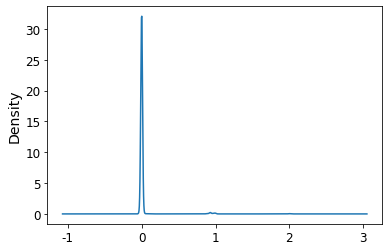

In [1127]:
pred_all[pred_all['x_test']==0]['pred'].plot.kde()

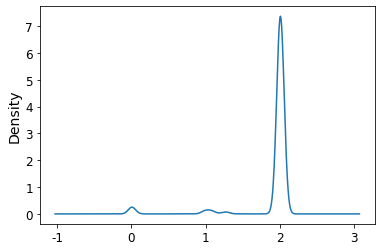

In [1129]:
pred_all[pred_all['x_test']==2]['pred'].plot.kde()

In [1049]:
target = X_test[2:3]

def get_reconstructed(X_feed, logits, model_path):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        logits_val = logits.eval(feed_dict={X_input: X_feed})
        return logits_val
    


return_val = get_reconstructed(target, logits, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num))
plt.scatter(return_val[0], target[0], alpha=0.1)
code_0 = get_code_0(X_test, logits, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num))
plt.scatter(code_0, code_0, alpha=1)

plt.scatter(return_val[0], target[0], alpha=0.5)

ValueError: The passed save_path is not a valid checkpoint: /home2/jpark/Projects/prs/model/cv_5_test_y_100_None_None

In [580]:
pd.DataFrame(y_test, columns=['y'])

,y
0,0
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [520]:
pd.DataFrame(code_0, columns=['X'])

,X
0,0.833514
1,0.833822
2,0.869191
3,0.869579
4,0.832944
...,...
780,0.869581
781,0.834013
782,0.869143
783,0.833779


In [522]:
pd.DataFrame(y_test, columns=['y'])

,y
0,0
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [543]:
temp_df = pd.concat([pd.DataFrame(code_0, columns=['X']), pd.DataFrame(y_test, columns=['y'])], axis=1)

In [544]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

model = LogisticRegressionCV(penalty='l2', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga',  random_state=2)

In [546]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

for col in ['X']:
    scaler = normalize(temp_df, col)

fitted_model = model.fit(temp_df[['X']], temp_df[['y']])

/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python36/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/bin2/pkg_python

In [548]:
roc_auc_score(temp_df[['y']], fitted_model.decision_function(temp_df[['X']]))

0.5808126868318386

In [542]:
roc_auc_score(temp_df[['y']], fitted_model.decision_function(temp_df[['X']]))

0.5808126868318386

In [ ]:
# Train
model = LogisticRegressionCV(penalty='l2', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga',  random_state=2)
fitted_model = model.fit(X_train, y_train)

# For test data
print('@ Test scores')
test_pred = fitted_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_score = precision_recall_fscore_support(y_test, test_pred)
test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
test_result_list.append([model_name, test_acc, test_score, test_auc])

In [ ]:
plt.boxplot(code_0[y_test==1])

(0, 0.9)

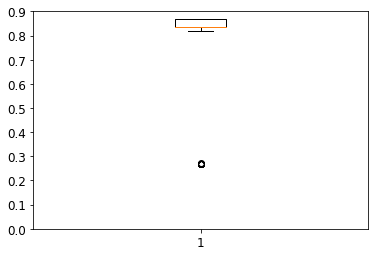

In [552]:
plt.boxplot(code_0[y_test==1])
plt.ylim(0, 0.9)

(0, 0.9)

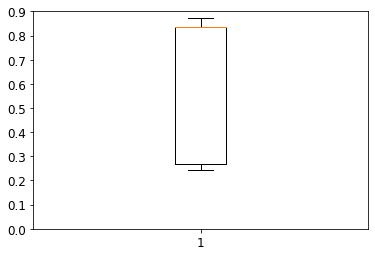

In [551]:
plt.boxplot(code_0[y_test==0])
plt.ylim(0, 0.9)